## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [ ]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.4)

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [ ]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])

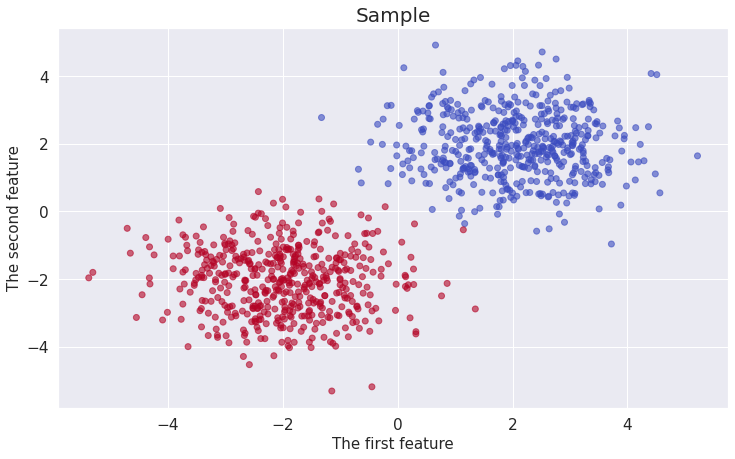

In [ ]:
plt.figure(figsize=(12, 7))
plt.title('Sample', fontsize=20)
plt.xlabel('The first feature', fontsize=15)
plt.ylabel('The second feature', fontsize=15)
plt.scatter(X[:,0],X[:,1], c = Y[:,0], cmap='coolwarm_r', alpha=0.6)
plt.show()

Define a **logistic regression** for debugging. 

In [ ]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

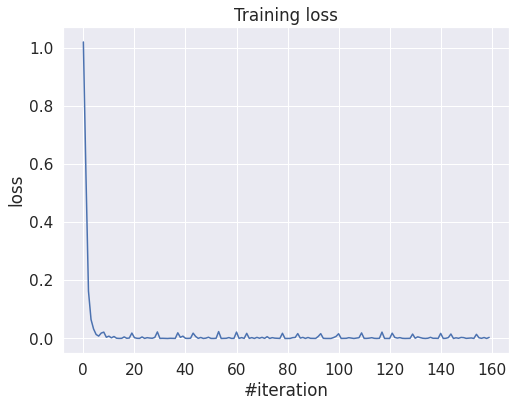

Current loss: 0.003793


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

Let's consider batch_size = 1000:

In [ ]:
net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 1000

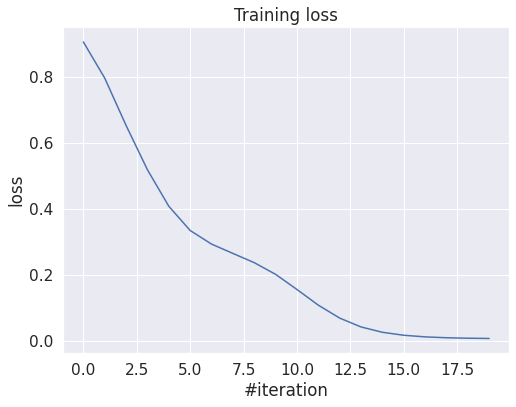

Current loss: 0.008615


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [ ]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

In [ ]:
print(f"Size of our train data is {X_train.shape}")
print(f"Size of our test data is {X_test.shape}")

Size of our train data is (50000, 784)
Size of our test data is (10000, 784)


One-hot encode the labels first.

In [ ]:
labels = len(np.unique(y_train))
train_samples_size = y_train.shape[0]
test_samples_size = y_test.shape[0]

def one_hot_encode(sample_size, labels, y):
    y_encoded = np.zeros((sample_size, labels))
    for i in range(sample_size):
        y_encoded[i, y[i]] = 1.0
    return y_encoded

In [ ]:
y_train = one_hot_encode(train_samples_size, labels, y_train)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [ ]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 5
batch_size = 1000

In [ ]:
def training_loop(net, X_train, y_train, n_epoch, batch_size):
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)
    return loss_history

In [ ]:
def draw_plot(losses, labels_of_losses, title):
    plt.figure(figsize=(15, 8))
    x = np.arange(len(losses[1]))
    for loss, label_of_loss in zip(losses, labels_of_losses):
        plt.plot(x, loss, label=label_of_loss)
    plt.legend(loc='best', fontsize=15)
    plt.title(title, fontsize=20)
    plt.xlabel("iteration", fontsize=15)
    plt.ylabel("training loss", fontsize=15)
    plt.show()

In [ ]:
n_in = X_train.shape[1]

# net for ELU
net_elu = Sequential()
net_elu.add(Linear(n_in, int(n_in / 2)))
net_elu.add(ELU())
net_elu.add(Linear(int(n_in / 2), int(n_in / 4)))
net_elu.add(ELU())
net_elu.add(Linear(int(n_in / 4), labels))
net_elu.add(LogSoftMax())

# net for ReLU
net_relu = Sequential()
net_relu.add(Linear(n_in, int(n_in / 2)))
net_relu.add(ReLU())
net_relu.add(Linear(int(n_in / 2), int(n_in / 4)))
net_relu.add(ReLU())
net_relu.add(Linear(int(n_in / 4), labels))
net_relu.add(LogSoftMax())

# net for LeakyReLU
net_leakyrelu = Sequential()
net_leakyrelu.add(Linear(n_in, int(n_in / 2)))
net_leakyrelu.add(LeakyReLU())
net_leakyrelu.add(Linear(int(n_in / 2), int(n_in / 4)))
net_leakyrelu.add(LeakyReLU())
net_leakyrelu.add(Linear(int(n_in / 4), labels))
net_leakyrelu.add(LogSoftMax())

# net for SoftPlus
net_softplus = Sequential()
net_softplus.add(Linear(n_in, int(n_in / 2)))
net_softplus.add(SoftPlus())
net_softplus.add(Linear(int(n_in / 2), int(n_in / 4)))
net_softplus.add(SoftPlus())
net_softplus.add(Linear(int(n_in / 4), labels))
net_softplus.add(LogSoftMax())

In [ ]:
losses_elu = training_loop(net_elu, X_train, y_train, n_epoch, batch_size)
losses_relu = training_loop(net_relu, X_train, y_train, n_epoch, batch_size)
losses_leakyrelu = training_loop(net_leakyrelu, X_train, y_train, n_epoch, batch_size)
losses_softplus = training_loop(net_softplus, X_train, y_train, n_epoch, batch_size)

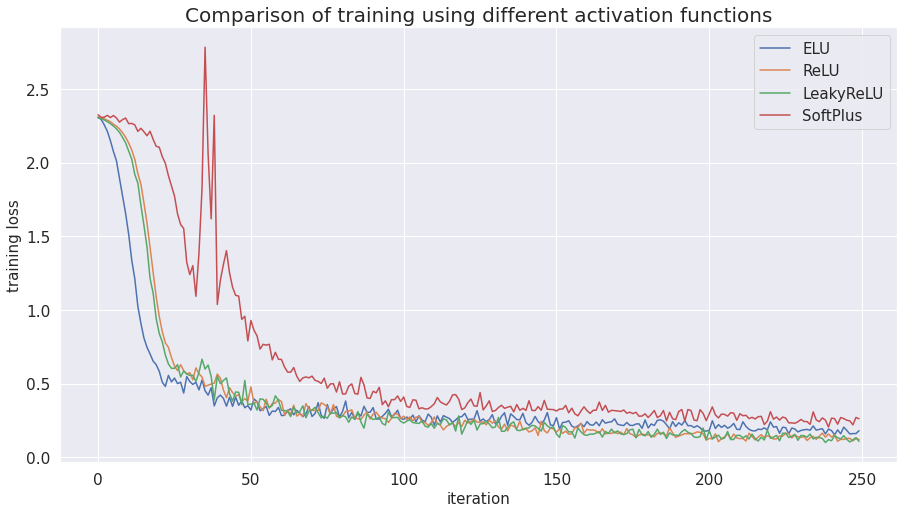

In [ ]:
losses = [losses_elu, losses_relu, losses_leakyrelu, losses_softplus]
labels_of_losses = ['ELU', 'ReLU', 'LeakyReLU', 'SoftPlus']
title = 'Comparison of training using different activation functions'
draw_plot(losses, labels_of_losses, title)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 5
batch_size = 1000

In [ ]:
# net for ELU with BatchNormalization
net_elu_with_bn = Sequential()
net_elu_with_bn.add(Linear(n_in, int(n_in / 2)))
net_elu_with_bn.add(BatchNormalization())
net_elu_with_bn.add(ChannelwiseScaling(int(n_in / 2)))
net_elu_with_bn.add(ELU())
net_elu_with_bn.add(Linear(int(n_in / 2), int(n_in / 4)))
net_elu_with_bn.add(BatchNormalization())
net_elu_with_bn.add(ChannelwiseScaling(int(n_in / 4)))
net_elu_with_bn.add(ELU())
net_elu_with_bn.add(Linear(int(n_in / 4), labels))
net_elu_with_bn.add(LogSoftMax())

# net for ReLU with BatchNormalization
net_relu_with_bn = Sequential()
net_relu_with_bn.add(Linear(n_in, int(n_in / 2)))
net_relu_with_bn.add(BatchNormalization())
net_relu_with_bn.add(ChannelwiseScaling(int(n_in / 2)))
net_relu_with_bn.add(ReLU())
net_relu_with_bn.add(Linear(int(n_in / 2), int(n_in / 4)))
net_relu_with_bn.add(BatchNormalization())
net_relu_with_bn.add(ChannelwiseScaling(int(n_in / 4)))
net_relu_with_bn.add(ReLU())
net_relu_with_bn.add(Linear(int(n_in / 4), labels))
net_relu_with_bn.add(LogSoftMax())

# net for LeakyReLU with BatchNormalization
net_leakyrelu_with_bn = Sequential()
net_leakyrelu_with_bn.add(Linear(n_in, int(n_in / 2)))
net_leakyrelu_with_bn.add(BatchNormalization())
net_leakyrelu_with_bn.add(ChannelwiseScaling(int(n_in / 2)))
net_leakyrelu_with_bn.add(LeakyReLU())
net_leakyrelu_with_bn.add(Linear(int(n_in / 2), int(n_in / 4)))
net_leakyrelu_with_bn.add(BatchNormalization())
net_leakyrelu_with_bn.add(ChannelwiseScaling(int(n_in / 4)))
net_leakyrelu_with_bn.add(LeakyReLU())
net_leakyrelu_with_bn.add(Linear(int(n_in / 4), labels))
net_leakyrelu_with_bn.add(LogSoftMax())

# net for SoftPlus with BatchNormalization
net_softplus_with_bn = Sequential()
net_softplus_with_bn.add(Linear(n_in, int(n_in / 2)))
net_softplus_with_bn.add(BatchNormalization())
net_softplus_with_bn.add(ChannelwiseScaling(int(n_in / 2)))
net_softplus_with_bn.add(SoftPlus())
net_softplus_with_bn.add(Linear(int(n_in / 2), int(n_in / 4)))
net_softplus_with_bn.add(BatchNormalization())
net_softplus_with_bn.add(ChannelwiseScaling(int(n_in / 4)))
net_softplus_with_bn.add(SoftPlus())
net_softplus_with_bn.add(Linear(int(n_in / 4), labels))
net_softplus_with_bn.add(LogSoftMax())

In [ ]:
losses_elu_with_bn = training_loop(net_elu_with_bn, X_train, y_train, n_epoch, batch_size)
losses_relu_with_bn = training_loop(net_relu_with_bn, X_train, y_train, n_epoch, batch_size)
losses_leakyrelu_with_bn = training_loop(net_leakyrelu_with_bn, X_train, y_train, n_epoch, batch_size)
losses_softplus_with_bn = training_loop(net_softplus_with_bn, X_train, y_train, n_epoch, batch_size)

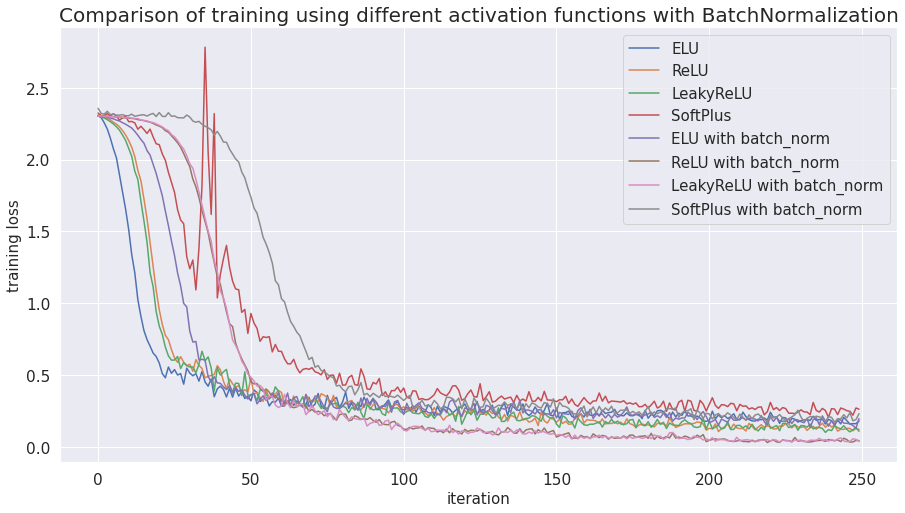

In [ ]:
losses = [losses_elu, losses_relu, losses_leakyrelu, losses_softplus,
          losses_elu_with_bn, losses_relu_with_bn, losses_leakyrelu_with_bn, losses_softplus_with_bn]
labels_of_losses = ['ELU', 'ReLU', 'LeakyReLU', 'SoftPlus',
                    'ELU with batch_norm', 'ReLU with batch_norm', 'LeakyReLU with batch_norm', 'SoftPlus with batch_norm']
title = 'Comparison of training using different activation functions with BatchNormalization'
draw_plot(losses, labels_of_losses, title)

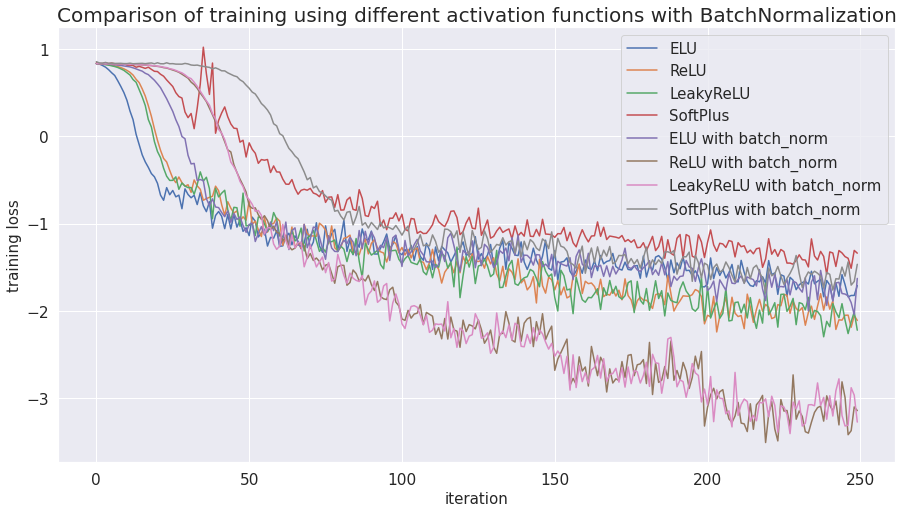

In [ ]:
draw_plot(np.log(losses), labels_of_losses, title)

As we can see, adding BatchNormalization improves learning for all models that differ only in activation functions.

Let's compare optimizers SGD_momentum and Adam:

In [ ]:
# Let's consider ReLU with Adam optimizer and BatchNormalization
net_relu_adam_with_bn = Sequential()
net_relu_adam_with_bn.add(Linear(n_in, int(n_in / 2)))
net_relu_adam_with_bn.add(BatchNormalization())
net_relu_adam_with_bn.add(ChannelwiseScaling(int(n_in / 2)))
net_relu_adam_with_bn.add(ReLU())
net_relu_adam_with_bn.add(Linear(int(n_in / 2), int(n_in / 4)))
net_relu_adam_with_bn.add(BatchNormalization())
net_relu_adam_with_bn.add(ChannelwiseScaling(int(n_in / 4)))
net_relu_adam_with_bn.add(ReLU())
net_relu_adam_with_bn.add(Linear(int(n_in / 4), labels))
net_relu_adam_with_bn.add(LogSoftMax())

In [ ]:
# Optimizer params
optimizer_config = {
    'learning_rate' : 1e-1,
    'beta1': 0.9,
    'beta2': 0.999,
    'epsilon': 1e-8
    }
optimizer_state = {}

# Looping params
n_epoch = 5
batch_size = 1000

In [ ]:
def training_loop_with_adam(net, X_train, y_train, n_epoch, batch_size):
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            adam_optimizer(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)
    return loss_history

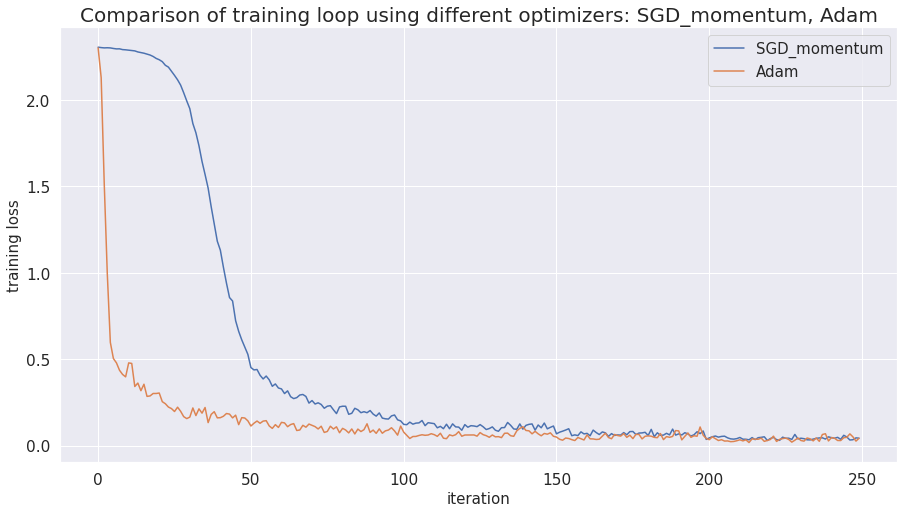

In [ ]:
losses_relu_adam = training_loop_with_adam(net_relu_adam_with_bn, X_train, y_train, n_epoch, batch_size)
losses = [losses_relu_with_bn, losses_relu_adam]
labels_of_losses = ['SGD_momentum', 'Adam']
title = 'Comparison of training loop using different optimizers: SGD_momentum, Adam'
draw_plot(losses, labels_of_losses, title)

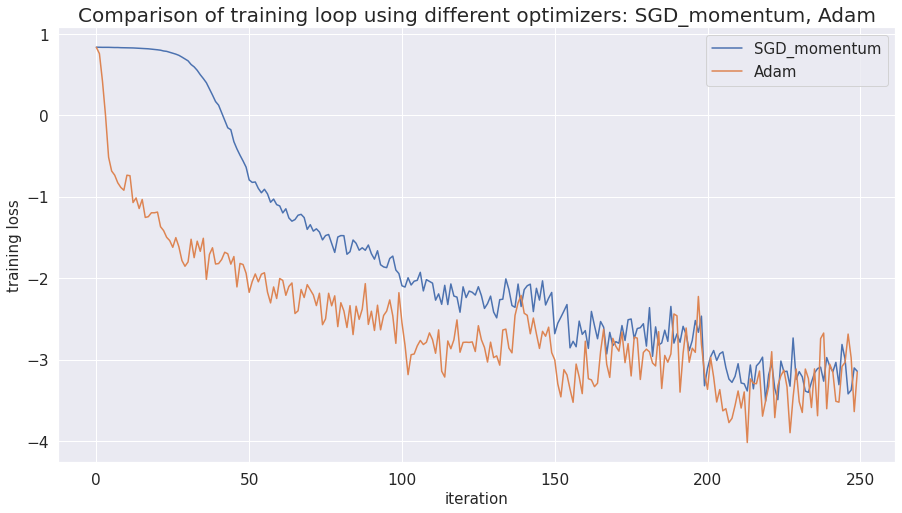

In [ ]:
draw_plot(np.log(losses), labels_of_losses, title)

As we can see, SGD_momentum optimizer performs better than Adam optimizer.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
cool_net = Sequential()
cool_net.add(Linear(n_in, int(n_in / 2)))
cool_net.add(Dropout())
cool_net.add(ReLU())
cool_net.add(Linear(int(n_in / 2), int(n_in / 4)))
cool_net.add(Dropout())
cool_net.add(ReLU())
cool_net.add(Linear(int(n_in / 4), labels))
cool_net.add(LogSoftMax())

In [ ]:
def training_loop(net, X_train, y_train, n_epoch, batch_size):
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)
        print('Current loss: %f' % loss)
    return loss_history

In [ ]:
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
criterion = ClassNLLCriterion()
n_epoch = 5
batch_size = 1000

In [ ]:
losses_cool = training_loop(cool_net, X_train, y_train, n_epoch, batch_size)

Current loss: 0.493642
Current loss: 0.357275
Current loss: 0.219982
Current loss: 0.235824
Current loss: 0.185736


In [ ]:
cool_net_with_bn = Sequential()
cool_net_with_bn.add(Linear(n_in, int(n_in / 2)))
cool_net_with_bn.add(BatchNormalization())
cool_net_with_bn.add(ChannelwiseScaling(int(n_in / 2)))
cool_net_with_bn.add(ReLU())
cool_net_with_bn.add(Linear(int(n_in / 2), int(n_in / 4)))
cool_net_with_bn.add(BatchNormalization())
cool_net_with_bn.add(ChannelwiseScaling(int(n_in / 4)))
cool_net_with_bn.add(ReLU())
cool_net_with_bn.add(Linear(int(n_in / 4), labels))
cool_net_with_bn.add(LogSoftMax())

In [ ]:
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
criterion = ClassNLLCriterion()
n_epoch = 5
batch_size = 1000

In [ ]:
losses_cool_with_bn = training_loop(cool_net_with_bn, X_train, y_train, n_epoch, batch_size)

Current loss: 0.503657
Current loss: 0.156696
Current loss: 0.107695
Current loss: 0.072080
Current loss: 0.043725


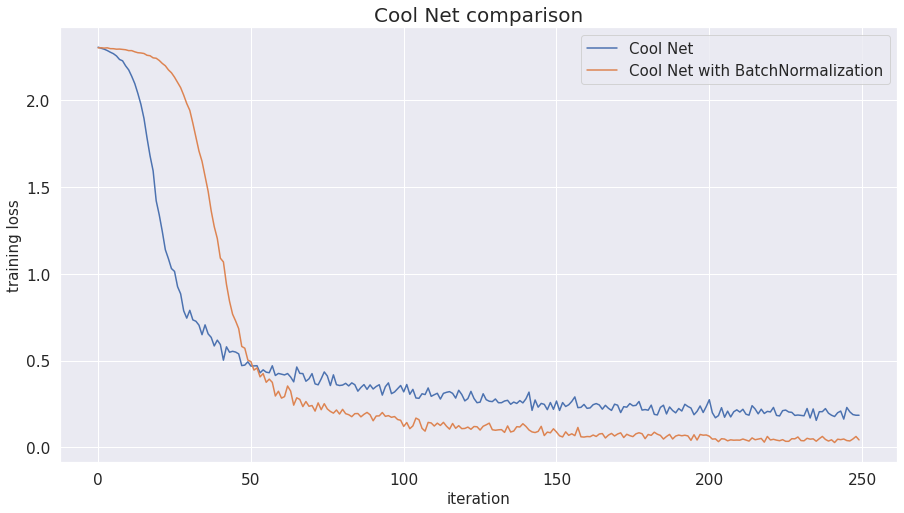

In [ ]:
losses = [losses_cool, losses_cool_with_bn]
labels_for_losses = ['Cool Net', 'Cool Net with BatchNormalization']
titles = 'Cool Net comparison'
draw_plot(losses, labels_for_losses, titles)

Print here your accuracy on test set. It should be around 90%.

In [ ]:
from sklearn.metrics import accuracy_score

Let's consider accuracy for model using Dropout:

In [ ]:
cool_net.evaluate()
predictions = cool_net.forward(X_test)
y_pred = np.argmax(predictions, axis=1)
print("Accuracy on test set in model with using dropout: %f" % accuracy_score(y_pred, y_test))

Accuracy on test set in model with using dropout: 0.959800


Let's consider accuracy for model using BatchNormalization:

In [ ]:
cool_net_with_bn.evaluate()
predictions = cool_net_with_bn.forward(X_test)
y_prediction = np.argmax(predictions, axis=1)
print("Accuracy on test set in model with using dropout: %f" % accuracy_score(y_prediction, y_test))

Accuracy on test set in model with using dropout: 0.978500


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn

In [ ]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

In [ ]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

<ipython-input-5-099d1f01789a>:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  y_train = torch.from_numpy(y_train)


In [ ]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=True)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
n_in = X_train.shape[1]
model = nn.Sequential(
    nn.Linear(n_in, int(n_in / 2)),
    nn.BatchNorm1d(int(n_in / 2)),
    nn.ReLU(),
    nn.Linear(int(n_in / 2), int(n_in / 4)),
    nn.BatchNorm1d(int(n_in / 4)),
    nn.ReLU(),
    nn.Linear(int(n_in / 4), 10),
    nn.LogSoftmax()
)

model.to(device, torch.float32)

Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=392, out_features=196, bias=True)
  (4): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=196, out_features=10, bias=True)
  (7): LogSoftmax(dim=None)
)

In [ ]:
n_epochs = 50
opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

In [ ]:
def training_loop(model, train_loader, val_loader, loss_func, opt, n_epochs):
  train_loss = []
  train_accuracy = []
  values_loss = []
  values_accuracy = []

  for epoch in range(n_epochs):
    train_loss_epoch = []
    train_accuracy_epoch = []
    values_loss_epoch = []
    values_accuracy_epoch = []

    model.train(True)
    for X_batch, y_batch in train_loader:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      opt.zero_grad()
      predictions = model(X_batch)
      y_predict = torch.argmax(predictions, axis=1)
      train_accuracy_epoch.append(torch.sum(y_predict==y_batch).item() / len(y_batch))
      loss = loss_func(predictions, y_batch)
      loss.backward()
      opt.step()
      train_loss_epoch.append(loss.item())
    
    model.train(False)
    with torch.no_grad():
      for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)
        loss = loss_func(predictions, y_batch)
        values_loss_epoch.append(loss.item())
        y_predict = torch.argmax(predictions, axis=1)
        values_accuracy_epoch.append(torch.sum(y_predict==y_batch).item() / len(y_batch))
    train_accuracy.append(np.mean(train_accuracy_epoch))
    train_loss.append(np.mean(train_loss_epoch))
    values_accuracy.append(np.mean(values_accuracy_epoch))
    values_loss.append(np.mean(values_loss_epoch))
  return train_accuracy, values_accuracy, train_loss, values_loss

In [ ]:
def print_details_training(train_accuracy, values_accuracy, train_loss, values_loss):
  print("==================================================")
  print(f" training loss in first iteration: {train_loss[0]:.6f}")
  print(f" validation loss in first iteration: {values_loss[0]:.6f}")
  print(f" training accuracy in first iteration: {train_accuracy[0]:.6f}")
  print(f" validation accuracy in first iteration: {values_accuracy[0]:.6f}")
  print("==================================================")
  print(f" training loss in last iteration: {train_loss[-1]:.6f}")
  print(f" validation loss in last iteration: {values_loss[-1]:.6f}")
  print(f" training accuracy in last iteration: {train_accuracy[-1]:.6f}")
  print(f" validation accuracy in last iteration: {values_accuracy[-1]:.6f}")
  print("==================================================")

In [ ]:
train_accuracy, values_accuracy, train_loss, values_loss = training_loop(model, train_loader, test_loader, loss_func, opt, n_epochs)
print_details_training(train_accuracy, values_accuracy, train_loss, values_loss)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 training loss in first iteration: 0.777746
 validation loss in first iteration: 0.319602
 training accuracy in first iteration: 0.797520
 validation accuracy in first iteration: 0.920200
 training loss in last iteration: 0.002541
 validation loss in last iteration: 0.063467
 training accuracy in last iteration: 1.000000
 validation accuracy in last iteration: 0.981000


In [ ]:
def plot_accuracy_and_loss(train_accuracy, values_accuracy, train_loss, values_loss):
  accuracies = [train_accuracy, values_accuracy]
  losses = [train_loss, values_loss]
  acc_losses = [accuracies, losses]
  title = ['Accuracy', 'Loss']
  for i in range(len(acc_losses)):
    plt.figure(figsize=(12, 7))
    plt.plot(acc_losses[i][0], label='train')
    plt.plot(acc_losses[i][1], label='validation')
    plt.legend(loc='best', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.title(title[i], fontsize=20)
    plt.show()

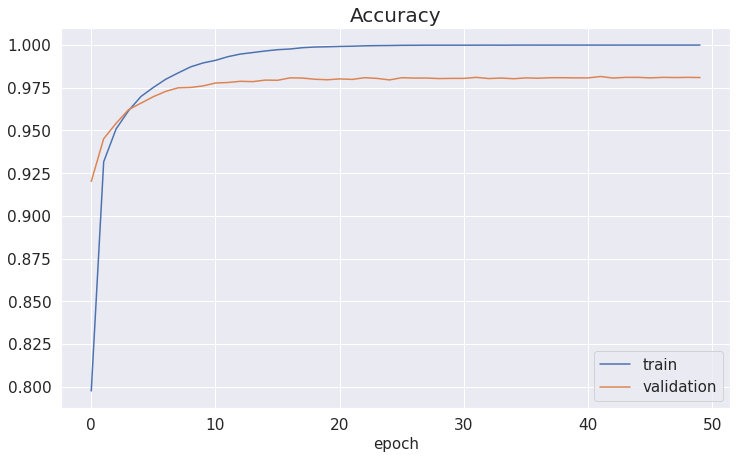

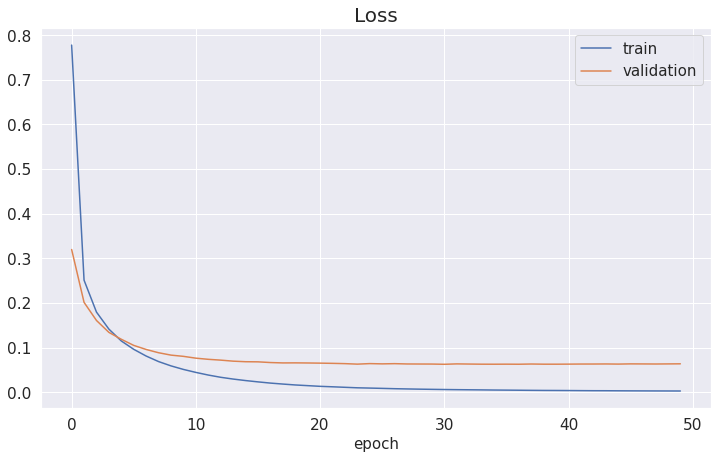

In [ ]:
plot_accuracy_and_loss(train_accuracy, values_accuracy, train_loss, values_loss)

In [ ]:
def print_testing_accuracy(model, test_loader):
  accuracy = []
  model.train(False)
  with torch.no_grad():
    for X_batch, y_batch in test_loader:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      predictions = model(X_batch)
      y_predict = torch.argmax(predictions, axis=1)
      accuracy.append(torch.sum(y_predict==y_batch).item() / len(y_batch))
  print("Test accuracy is: ", np.mean(accuracy))

In [ ]:
print_testing_accuracy(model, test_loader)

Test accuracy is:  0.9810000000000001


As we can see, Accuracy on Test reached 0.98.